## Import packages

In [6]:
import time
import warnings
import pickle as pkl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pmd

plt.style.use('ggplot')

warnings.filterwarnings("ignore")

# Process Data


In [9]:
# import dataset

price = pd.read_csv("crude_oil_price.csv", index_col=0, header=0,
                    parse_dates=['Date'], squeeze=True)

print(type(price))

<class 'pandas.core.series.Series'>


In [10]:
# first five columns

price.head()

Date
2009-10-23    80.49
2009-11-04    78.93
2009-11-06    78.65
2009-11-11    78.54
2009-11-13    76.71
Name: crude_oil_price [$], dtype: float64

In [11]:
price.shape

(3203,)

In [12]:
# some information about data
price.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3203 entries, 2009-10-23 to 2023-09-04
Series name: crude_oil_price [$]
Non-Null Count  Dtype  
--------------  -----  
3203 non-null   float64
dtypes: float64(1)
memory usage: 50.0 KB


In [13]:
# check for null values

price.isna().sum()

0

## Explore data

In [14]:
#summary statistics

price.describe()

count    3203.000000
mean       78.932986
std        27.087447
min         7.150000
25%        56.510000
50%        76.480000
75%       107.275000
max       139.410000
Name: crude_oil_price [$], dtype: float64

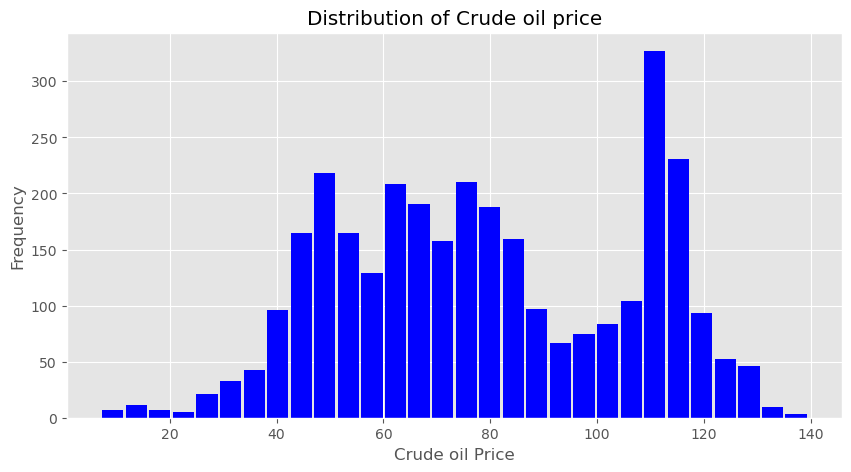

In [15]:
# we make a histogram of the crude oil price

fig, ax = plt.subplots(figsize=(10,5))
price.hist(bins=30, rwidth=0.9,ax=ax, color='b')
plt.xlabel('Crude oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Crude oil price');

The distribution of the crude oil prices appears to be skewed to the right, indicating that there are more occurrences of lower prices compared to higher prices. Additionally, we can see the range of prices and the frequency of occurrence within each range. There are very low occurences of crude oil prices below $40.

In [17]:
# we make a line plot of the times series data

px.line(price, labels={'value':'crude_oil_price [$]'})

The line plot above shows the trend of crude oil prices over time. From the plot, we can observe a sharp fall in prices around the year 2020. This significant drop in prices can be attributed to the COVID-19 pandemic and its impact on global oil demand.

Other observations from the visualization include:

Prior to 2020, the crude oil prices were relatively stable with some fluctuations. There is a general upward trend in prices from the beginning of the time series until around 2014. After 2014, there is a period of volatility with both upward and downward movements in prices. The sharp fall in prices around 2020 is followed by a gradual recovery.  

The plot also shows that there is a trend in our series data and therefore our data may not be stationary




## Check for stationarity of time series

ARIMA models are usually applied on stationary times series, therefore, we must check for stationarity in our times series before applying ARIMA model. 

we will use the ***ACF and PCF plots as well as the Augmented Dicky-Fuller test (ADF)*** to check stationarity in our data. 

> **ACF AND PACF PLOT**

The Autocorrelation function is the correlation of the times series with it's lags. It measures the linear relationship between lagged values of the time series. We can measure the autocorrelation of y<sub>t</sub> with y<sub>t-k</sub> for different values of k

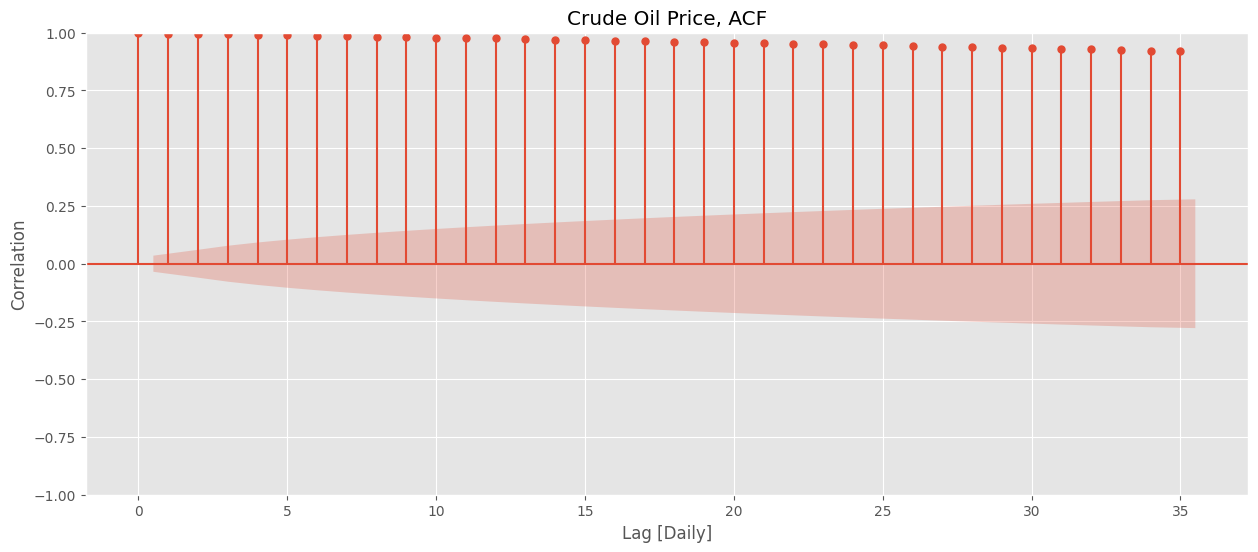

In [16]:
# ACF plot

fig, ax = plt.subplots(figsize=(15,6))
plot_acf(price, ax=ax)
plt.xlabel('Lag [Daily]')
plt.ylabel('Correlation')
plt.title('Crude Oil Price, ACF');

In the ACF plot above, the correlation coefficients gradually decrease as the lag increases, indicating a weak positive correlation between the current value and its past values. However, there are a few significant spikes at certain lags, suggesting the presence of some seasonality or trend in the data.

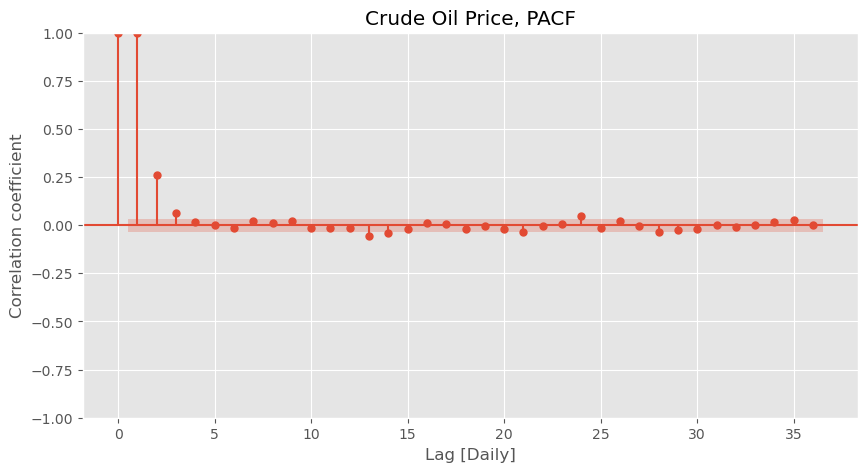

In [18]:
# ACF plot

fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(price, ax=ax)
plt.xlabel('Lag [Daily]')
plt.ylabel('Correlation coefficient')
plt.title('Crude Oil Price, PACF');

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are used to analyze the correlation between a time series and its lagged values.

The ACF plot shows the correlation coefficients between the time series and its lagged values at different lags. It helps identify the presence of any autocorrelation in the data. In the ACF plot above, the correlation coefficients gradually decrease as the lag increases, indicating a weak positive correlation between the current value and its past values. However, there are a few significant spikes at certain lags, suggesting the presence of some seasonality or trend in the data.

The PACF plot, on the other hand, shows the correlation coefficients between the time series and its lagged values after removing the effects of the intermediate lags. It helps identify the direct relationship between the current value and its past values. In the PACF plot above, the correlation coefficients drop off quickly after the first few lags, indicating a strong direct relationship between the current value and its immediate past values.

In [19]:
# implement ADF test

adf_test = adfuller(price)
print(f'P-value: {adf_test[1]}')

P-value: 0.40170016716848433


This test provides a large P-value , which provides strong evidence that our series data is not stationary

# Split dataset

We would use **90%** of our data for training and keep the remaining **10%** for testing

In [20]:
# split data

cut_off = int(len(price) *0.9) # series data is split chronologically in a horizontal manner
y_train = price.iloc[:cut_off]
y_test =  price.iloc[cut_off:]

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2882,)
y_test shape: (321,)


In [21]:
# checking our split data

print(len(y_train) + len(y_test) == len(price))

True


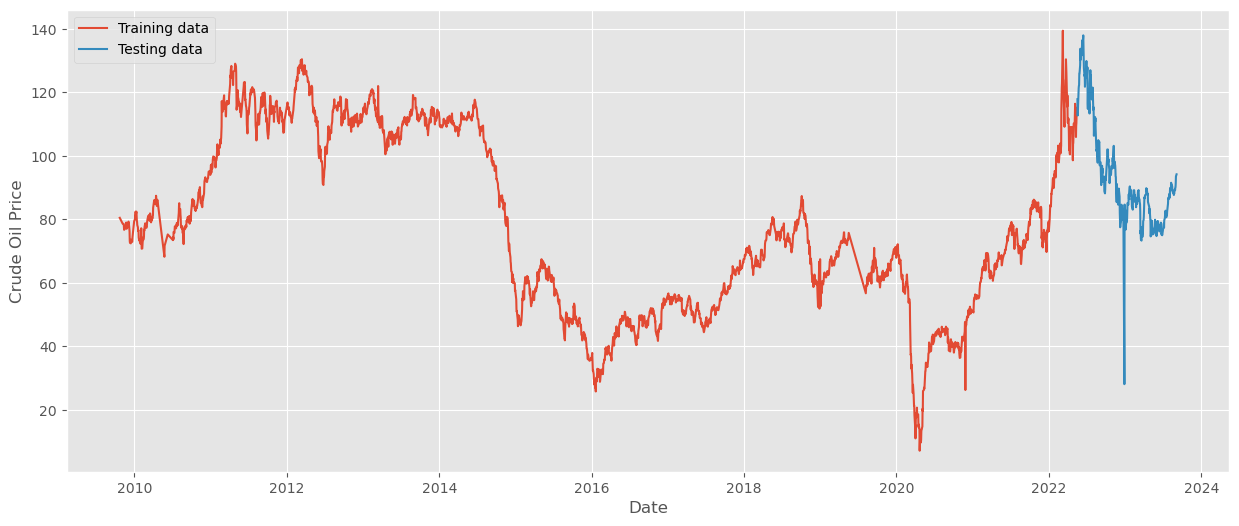

In [22]:
# plot training and test data

plt.figure(figsize=(15,6))
plt.plot(y_train, label='Training data')
plt.plot(y_test, label='Testing data')
plt.ylabel('Crude Oil Price')
plt.xlabel('Date')
plt.legend();

# Build Model


### Baseline Model

We build our ***baseline mean absolute error***.

In [23]:
y_mean = y_train.mean()
y_pred_baseline= [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f"Mean Price: {round(y_mean,2)}")
print(f"MAE Baseline: {round(mae_baseline,2)}")

Mean Price: 77.33
MAE Baseline: 23.71


# Iterate

### GridSearch (Tuning p,d,q) using auto_arima 

Since we are using **ARIMA** model for this times series analysis and we know that **ARIMA** model requires three parameters, we are going to grid search to find optimum parameters for our model.

**ARIMA PARAMETERS:**
1. p (lag order): Since we are using the past data to predict the future, we are going to make the range of past values (lags) to be a bit larger (i.e far back in time)

2. d (differencing order): we will keep this to just range of 2

3. q (Moving Average): These are kind of quick short term shock to the system, so a range of 3 numbers will be fine.

In [24]:
# auto_arima to find pdq

def arimamodel(train_data):
    autoarima_model = pmd.auto_arima(train_data,
                                    start_p=1, max_p=5,
                                    start_q=1, max_q=5,
                                    start_P=0, D=0,
                                    d = None,          # let model determine 'd'
                                    test='adf',        # uses adftest to find optimal 'd'
                                    trace=True)
    
    return autoarima_model

In [25]:
arima_model = arimamodel(y_train)

print(f"Optimal ARIMA parameters: {arima_model}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11513.659, Time=4.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11534.909, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11512.607, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11513.476, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11533.039, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11513.912, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11515.537, Time=2.81 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11510.763, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11512.064, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11511.810, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11511.633, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=11513.689, Time=1.77 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 12.989 seconds
Optimal ARIMA parameters:  ARIMA(1,1,0)(0,0,0)[0]          


From our GridSearch, we found that ARIMA(1,1,0) is our optimal value since it has the lowest AIC. Next, we go for residuals diagnostics

## Residuals

In [26]:
model = ARIMA(y_train, order=(1,1,0)).fit()

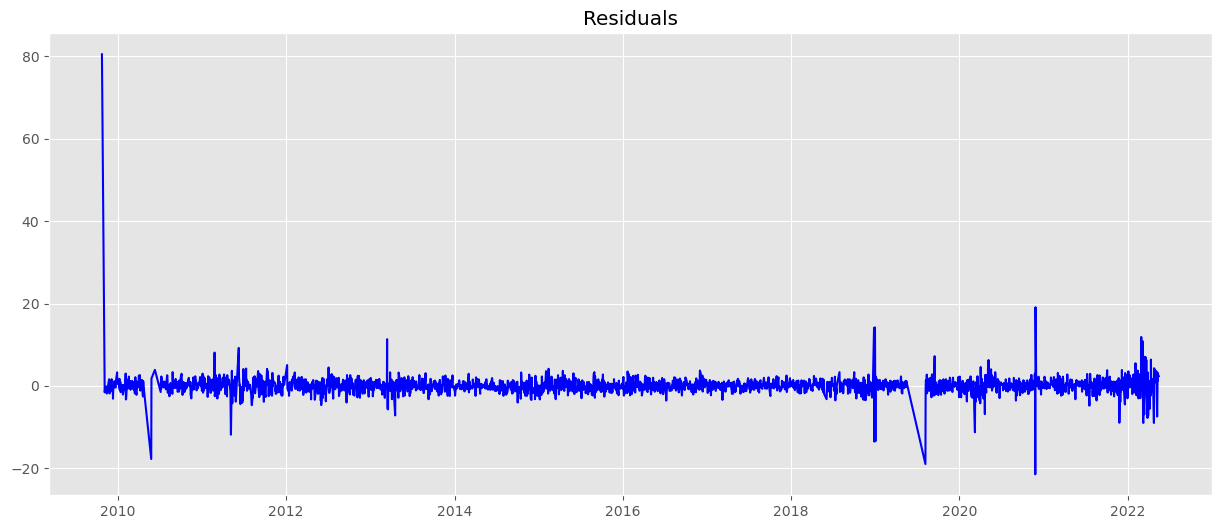

In [27]:
# Line plot of Residuals

residuals = model.resid

fig, ax = plt.subplots(figsize=(15,6))
plt.plot(residuals, color='b')
plt.title('Residuals');

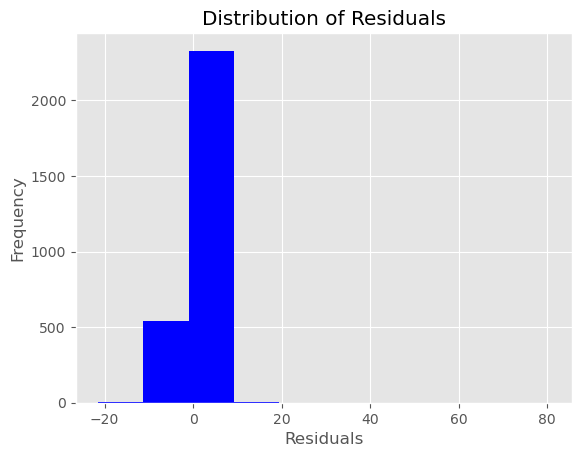

In [28]:
# histogram of residuals
plt.hist(residuals, color = 'b')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals');

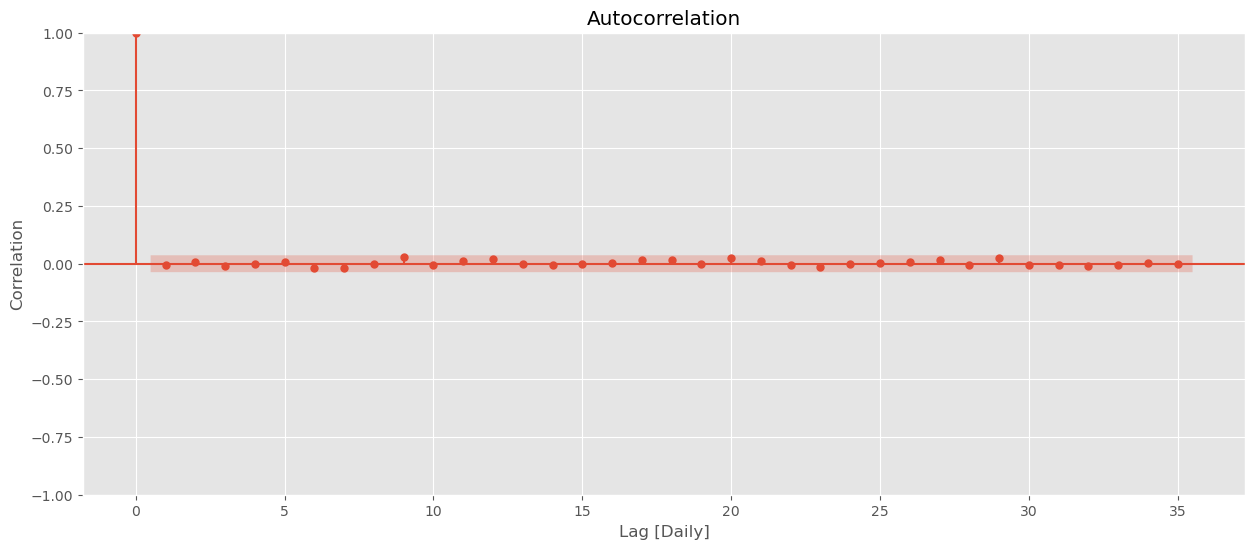

In [29]:
#plot ACF of Residuals

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(residuals, ax=ax)
plt.xlabel('Lag [Daily]')
plt.ylabel("Correlation");

AS can be observed from the figures above above, most of the residual points are spread around 0, with no recognizable patterns. The histrogram plot of the residuals is also looking like a normal distribution.

Looking ath the ACF plot of the model residuals, it suggests that our model did a good job in capturing the trend in our times series; there are no significant correlations present and no observable irregular pattern formed.

Therefore, it is reasonable to conclude that the model is satisfactory.

# Evaluate

We are going to perform a walk-form validation on our y_test data.

In [30]:
# Walk-forward validation
history = list(y_train)
predictions = []

for i in range(len(y_test)):
    
        
    # Fit the ARIMA model on the history data
    model = ARIMA(history, order=(1,1,0))  # ARIMA(p, d, q) order
    result = model.fit()
    
    
    # Make a one-step forecast
    output = result.forecast()  # Access the first value of the forecast tuple
    
    # Append predicted value
    predictions.append(output[0])
    
    # Update training data
    actual_test_value = y_test[i]
    history.append(actual_test_value)
    

    # calculate mean absolute error

test_mae = mean_absolute_error(y_test,predictions)
print("Test MAE (walk forward validation):", round(test_mae, 2))  

Test MAE (walk forward validation): 2.12


In [32]:
# save the model

with open("arima_model_pkl", "wb") as pickle_file:
    pkl.dump(result, pickle_file)

# Communicate Result

In [33]:
# build a dataframe of the testing data model result

result_df = pd.DataFrame({"Actual Price":y_test,
                      "Predicted Price":predictions},
                     index = y_test.index)

result_df.head()

,Actual Price,Predicted Price
Date,,
2022-05-17,117.85,114.936706
2022-05-18,112.71,117.602635
2022-05-19,113.32,113.184848
2022-05-20,115.75,113.263601
2022-05-23,121.33,115.525725


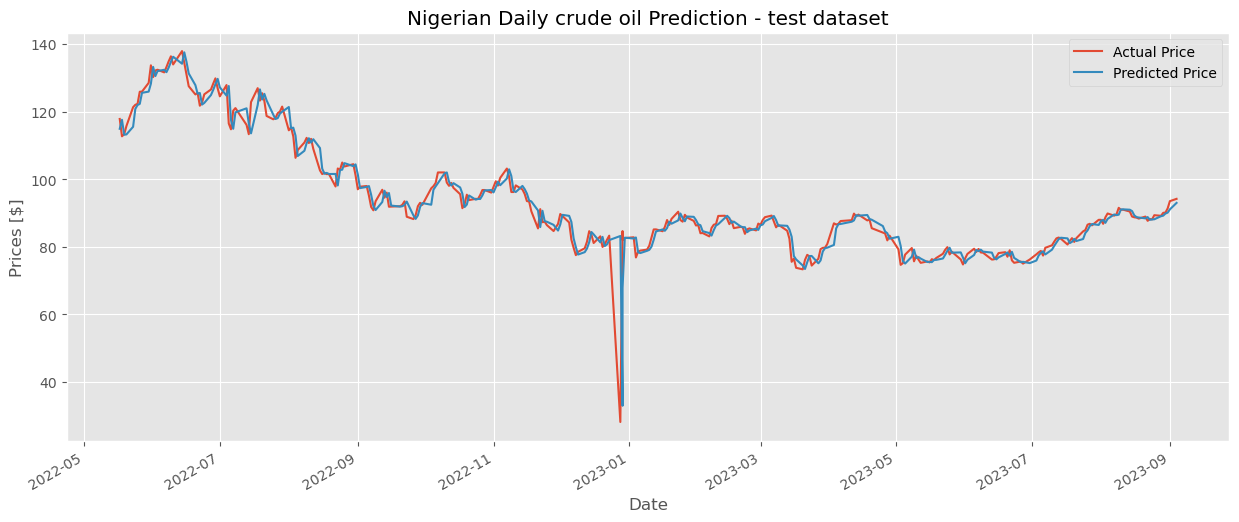

In [34]:
# make a plot of the result

fig, ax = plt.subplots(figsize=(15,6))
# make a plot of the result
result_df.plot(ax=ax)
plt.title("Nigerian Daily crude oil Prediction - test dataset")
plt.ylabel("Prices [$]");

## Forecast Future Periods

Here, We will try to make a forecast of the Nigerian crude oil price for the remaining days of 2023.

In [35]:
n_periods = 118  # from sept 4, 2023 (last day in our data) till Dec 31, 2023.

# stepwise forecasting
with open("arima_model_pkl", "rb") as file:
    arima_model = pkl.load(file)
    
forecast = arima_model.get_forecast(steps=n_periods)
    
# get the summary of the forecasted data
forecast_df = forecast.summary_frame()

In [39]:
# build dataframe of forecast values
forecast_df.index = pd.date_range(start=price.index[-1],
                                  periods=n_periods+1)[1:] # starts from the next day after last day in the dataset 

# rename the index
forecast_df.index.rename("future_date", inplace=True)

print("\n\nForecast of Nigerian crude oil price for the next 180 days, starting from June 6, 2023 to December 31, 2023")
forecast_df.head()



Forecast of Nigerian crude oil price for the next 180 days, starting from June 6, 2023 to December 31, 2023


y,mean,mean_se,mean_ci_lower,mean_ci_upper
future_date,,,,
2023-09-05,92.990405,2.249694,88.581085,97.399725
2023-09-06,93.116563,2.821865,87.585810,98.647317
2023-09-07,93.085932,3.366623,86.487473,99.684392
2023-09-08,93.093369,3.819446,85.607393,100.579345
2023-09-09,93.091564,4.227346,84.806119,101.377009


In the code above, the pd.date_range() function is used to create a new date range for the forecasted periods. The start parameter is set to the last date of the available data (data.index[-1]), and the periods parameter is set to n_periods + 1 to include both the last observed date and the future forecast periods. The [1:] indexing is used to exclude the first date (the last observed date) from the date range.

We are going to make a plot of our forecast values.

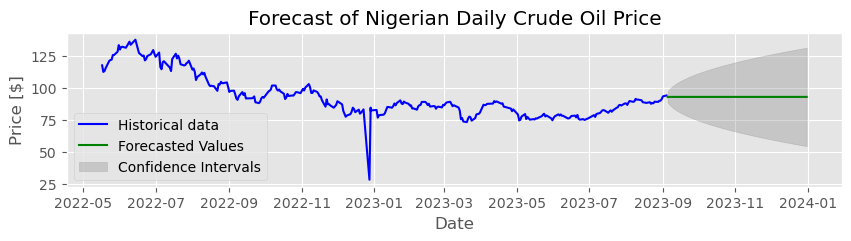

In [37]:
# make a plot

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(y_test,color='blue',label='Historical data')
ax.plot(forecast_df.index, forecast_df['mean'], color='green', label='Forecasted Values')
ax.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                color='gray', alpha=0.3, label='Confidence Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Price [$]')
ax.set_title('Forecast of Nigerian Daily Crude Oil Price')
ax.legend(loc='lower left');

## Conclusion

The AutoRegressive Integrated Moving Average (ARIMA) was used as a model to analyse the Nigerian daily crude oil price from october 23, 2009 to September 4, 2023. After parameter tuning (GridSearch), ARIMA(1,1,0) was chosen as the optimal model. The model was concluded as satisafactory for forecasting since the ACF and PACF of the residuals do not form any irregular pattern. The model was used to forecast Nigerian crude oil price for the next 118 days, starting from September 5, 2023 to December 31, 2023. The forecasted values of the Nigerian daily crude oil price were observed to be between  $88.58 - $131.71 by the end of the year, 2023. The evaluation metric used indicated that the forecasted values are relatively accurate.